In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# plotting parameters
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

from utils import read
from rockprops import *

In [2]:
# indicate the name of the file you want to analyze 

# this file should follow the format in input_template
file_location = 'input/input.xlsx'
# read the excel file into pandas and return the required parameters
bit_area, mud_weight, logs_values = read(file_location)

In [3]:
# obtain different drilling values to calculate rock properties from logs_values
md = logs_values['Hole depth'].values
rop = logs_values['Rate of penetration'].values
rpm = logs_values['Round per minute'].values
torque = logs_values['Torque'].values
wob = logs_values['Weight on bit'].values
diff_pres = logs_values['Differential pressure'].values
inclination = logs_values['Inclination'].values
gr = logs_values['Gamma ray'].values

In [4]:
# calculate pressure-related parameters

# hydrostatic pressure
Phyd = hydsta_pres(mud_weight, md, inclination, inclination_threshold=90)
# confined pressure
Pc = conf_pres(Phyd, mud_weight)

In [5]:
# calculate different rock properties
# constant related to calculation
BIT_EFFICIENCY = 0.7
GR_CUTOFF = 60

# mechanical specific energy, psi
mse = calculate_mse(wob, bit_area, rpm, torque, rop)
# unconfined compressive strength, psi
    # pump_efficiency is changeable
ucs = calculate_ucs(mse, pump_efficiency=BIT_EFFICIENCY)
# porosity, fraction
    # method 1 and 2 required gr_cutoff 
    # method 3 does not
porosity = calculate_porosity(ucs, gr, method=2, gr_cutoff=GR_CUTOFF)
# permeability, nD
    # method 1 is the only published data from measurement related to method 1
permeability = calculate_permeability(porosity, method=1)
# confined compressive strength, psi
ccs = calculate_ccs(ucs, gr, diff_pres, gr_cutoff=GR_CUTOFF)
# young modulus, GPa
E = calculate_youngmodulus(ccs, Pc)

[]

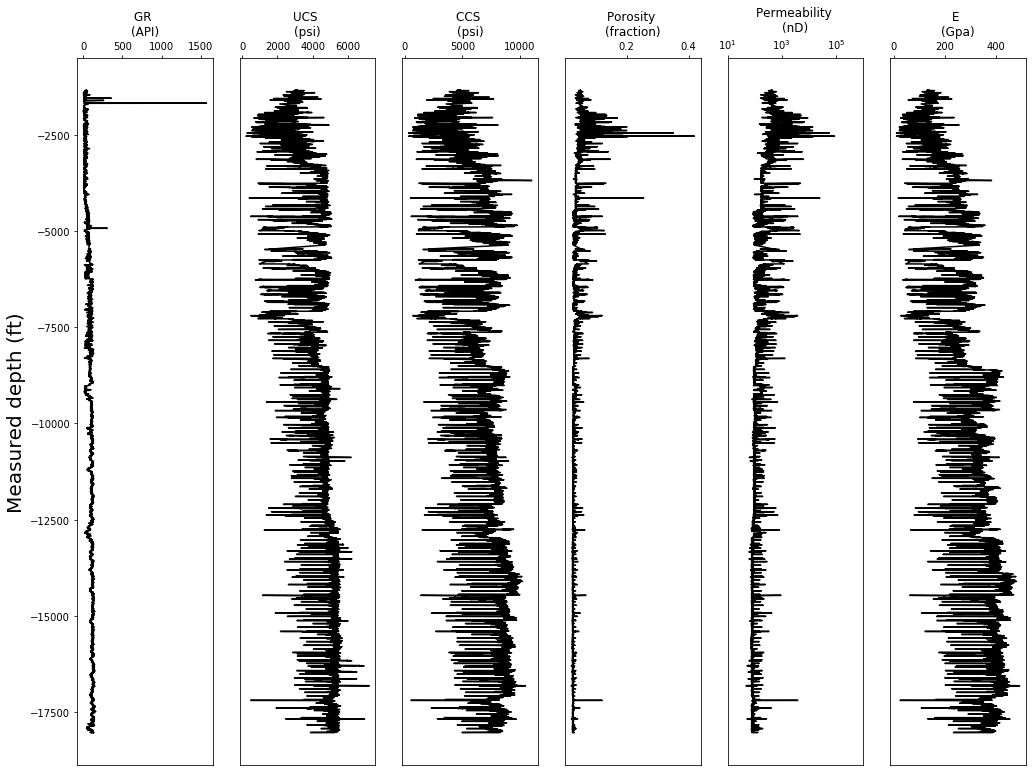

In [6]:
# plot rockprops altogether
fig = plt.figure(figsize=(17, 13))

# plot gr
gr_ax = fig.add_subplot(161)
gr_ax.plot(gr, -md, color='black')
gr_ax.set_title('GR \n(API)')
gr_ax.set_ylabel('Measured depth (ft)', size=20)

# plot ucs
ucs_ax = fig.add_subplot(162)
ucs_ax.plot(ucs, -md, color='black')
ucs_ax.set_title('UCS \n(psi)')
ucs_ax.set_yticks([])

# plot ccs
ccs_ax = fig.add_subplot(163)
ccs_ax.plot(ccs, -md, color='black')
ccs_ax.set_title('CCS \n(psi)')
ccs_ax.set_yticks([])

# plot porosity
poro_ax = fig.add_subplot(164)
poro_ax.plot(porosity, -md, color='black')
poro_ax.set_title('Porosity \n(fraction)')
poro_ax.set_yticks([])

# plot permeability
perm_ax = fig.add_subplot(165)
perm_ax.plot(permeability, -md, color='black')
perm_ax.set_xscale('log')
perm_ax.set_xlim([1e1, 1e6])
perm_ax.set_title('Permeability \n(nD)')
perm_ax.set_yticks([])

# plot youngmodulus
E_ax = fig.add_subplot(166)
E_ax.plot(E, -md, color='black')
E_ax.set_title('E \n(Gpa)')
E_ax.set_yticks([])

In [7]:
# save figure to output
fig.savefig('output/output.pdf')

In [8]:
# save your calculation of rock props to an excel file
logs_values.insert(logs_values.shape[1], 'Porosity', porosity)
logs_values.insert(logs_values.shape[1], 'Permeability', permeability)
logs_values.insert(logs_values.shape[1], 'UCS', ucs)
logs_values.insert(logs_values.shape[1], 'CCS', ccs)
logs_values.insert(logs_values.shape[1], 'E', E)



In [9]:
new_df = pd.DataFrame(logs_values)
new_df.to_excel('output/output.xlsx')